In [49]:
from pathlib import Path
from tqdm import tqdm
import datetime as dt

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

from HMC import HMC
from flux_preprocessing import load_dataset
from flux_utlis import fluxes_SIF_predict_noSIF, get_layer_model

%matplotlib inline
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13
data_dir = Path("../data")

In [50]:
train, test, EV1_train1, EV2_train1, NEE_train1, label_train, EV1_test1, EV2_test1, NEE_test, label_test, NEE_max_abs = load_dataset(
    'NNinput_SCOPE_US_Ha1_1314.csv')

In [51]:
train.head()

,Tair,Tsoil,T_leaf,T_canopy,RH,ea,u,fesc,fesc1,LAI,...,SIFcanopy_760nm,LUE_canopy,SIFyield_canopy,Date,Time,APAR_label,NEE_night,SIF_obs,NEE_obs,train_label
2013-06-19 00:00:00,12.6,18.77,14.49,12.74,94.50072,13.847,1.4,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,00:00:00,0,3.327953,0.0000,4.062361,Training set
2013-06-19 01:00:00,12.3,17.72,13.87,12.19,95.70137,13.746,1.5,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,01:00:00,0,3.327953,0.0000,3.681533,Training set
2013-06-19 02:00:00,11.9,16.87,13.05,11.63,93.79667,13.118,2.0,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,02:00:00,0,3.327953,0.0000,3.323355,Training set
2013-06-19 03:00:00,11.3,16.13,12.35,11.04,92.09961,12.374,2.3,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,03:00:00,0,3.327953,0.0000,3.450334,Training set
2013-06-19 04:00:00,11.2,15.43,12.33,10.98,88.10334,11.758,3.0,0.0,0.0,4.221,...,0.0093,0.0,0.0,2013-06-19,04:00:00,0,3.327953,0.0093,2.939732,Training set


In [52]:
test.head()

,Tair,Tsoil,T_leaf,T_canopy,RH,ea,u,fesc,fesc1,LAI,...,SIFcanopy_760nm,LUE_canopy,SIFyield_canopy,Date,Time,APAR_label,NEE_night,SIF_obs,NEE_obs,train_label
2014-07-30 02:00:00,14.1,16.68,16.02,14.06,95.102810,15.387,1.2,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,02:00:00,0,2.930302,0.000000,3.656422,Test set
2014-07-30 03:00:00,14.2,16.69,16.36,14.11,96.401980,15.700,0.9,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,03:00:00,0,2.930302,0.000000,3.237207,Test set
2014-07-30 04:00:00,13.9,16.54,15.90,13.86,96.099170,15.345,1.1,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,04:00:00,0,2.930302,0.000000,2.939725,Test set
2014-07-30 05:00:00,14.2,16.48,16.98,14.19,96.101105,15.651,1.2,0.000000,0.000000,3.955,...,0.0290,0.000000,0.000000,2014-07-30,05:00:00,0,2.930302,0.029000,2.004546,Test set
2014-07-30 07:00:00,16.9,17.26,20.07,17.89,82.498240,16.016,0.3,0.386452,0.429911,3.955,...,0.4536,0.033081,0.001314,2014-07-30,07:00:00,1,2.930302,0.323642,-7.951776,Test set


In [53]:
def NN_noSIF(n_neuron, activation1, activation2):
    # GPP
    APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
    EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
    x = Dense(n_neuron, activation=activation1, name='hidden1_1', use_bias=True)(EV_input1)
    x = Dense(n_neuron, activation=activation2, name='hidden1_2')(x)
    ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
    GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
    GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

    # Reco
    EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
    x = Dense(n_neuron, activation=activation1, name='hidden2_1', use_bias=True)(EV_input2)
    x = Dense(n_neuron, activation=activation2, name='hidden2_2')(x)
    ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
    Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

    NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

    model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
    model_NEE.compile(
        optimizer=keras.optimizers.Adam(5e-3),
        loss=keras.losses.MeanSquaredError()
    )

    return model_NEE

In [54]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
model_noSIF = NN_noSIF(n_neuron=64, activation1='relu', activation2='relu')
hist_noSIF = model_noSIF.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)

In [55]:
model_noSIF.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EV_input1 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 EV_input2 (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 hidden1_1 (Dense)              (None, 64)           448         ['EV_input1[0][0]']              
                                                                                                  
 hidden2_1 (Dense)              (None, 64)           320         ['EV_input2[0][0]']              
                                                                                           

In [56]:
burn_in = 2000
n_iter = 4000

n_obs_train = NEE_train1.shape[0]
n_obs_test = NEE_test.shape[0]


def sample(model, inputs):
    # Create HMC super-model
    n_obs = inputs[1].shape[0]
    hmc = HMC(model, L=15, epsilon_min=3e-3, epsilon_max=3e-3, batch_size=n_obs, n_obs=n_obs)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    hamiltonians = []
    acceptance = []

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted, h = hmc(inputs, tf.constant(step, dtype=tf.float32),
                                              tf.constant(n_iter, dtype=tf.float32))

        # bookkeeping
        if step > burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)
            hamiltonians.append(h)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    hamiltonians = tf.concat(hamiltonians, axis=0).numpy()
    acceptance = np.array(acceptance)
    print(f"Sampling done: {n_iter} steps with accepting rate {np.mean(acceptance)}")
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance

In [57]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance = sample(model_noSIF, (
    {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

100%|██████████| 6000/6000 [01:47<00:00, 55.81it/s]


Sampling done: 4000 steps with accepting rate 0.7784446111527882


In [58]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
NEE_train_MAP, GPP_train_MAP, Reco_train_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_train, EV1_train1, EV2_train1,
                                                                        NEE_max_abs)
NEE_test_MAP, GPP_test_MAP, Reco_test_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_test, EV1_test1, EV2_test1,
                                                                     NEE_max_abs)

# preparing sampling
precision = np.exp(log_gamma)
n_samples = 1000
NEE_train_traj, GPP_train_traj, Reco_train_traj = np.zeros((n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples))
NEE_test_traj, GPP_test_traj, Reco_test_traj = np.zeros((n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples))
sigma_NEE = np.std(train["NEE_canopy"])
sigma_GPP = np.std(train["GPP_canopy"])
sigma_Reco = np.std(train["Reco_canopy"])

# sampling
model_NEE = get_layer_model(hmc.model, "NEE")
model_GPP = get_layer_model(hmc.model, "GPP")
model_Reco = get_layer_model(hmc.model, "Reco")
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2]
    hmc.set_model_params(w_sample)

    NEE_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_train,
                                                                 'EV_input1': EV1_train1,
                                                                 'EV_input2': EV2_train1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

    NEE_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_test,
                                                                'EV_input1': EV1_test1,
                                                                'EV_input2': EV2_test1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

mu_NEE_train = np.mean(NEE_train_traj, axis=1)
mu_GPP_train = np.mean(GPP_train_traj, axis=1)
mu_Reco_train = np.mean(Reco_train_traj, axis=1)

sigma_NEE_pred_train = np.var(NEE_train_traj, axis=1)
sigma_GPP_pred_train = np.var(GPP_train_traj, axis=1)
sigma_Reco_pred_train = np.var(Reco_train_traj, axis=1)

mu_NEE_test = np.mean(NEE_test_traj, axis=1)
mu_GPP_test = np.mean(GPP_test_traj, axis=1)
mu_Reco_test = np.mean(Reco_test_traj, axis=1)

sigma_NEE_pred_test = np.var(NEE_test_traj, axis=1)
sigma_GPP_pred_test = np.var(GPP_test_traj, axis=1)
sigma_Reco_pred_test = np.var(Reco_test_traj, axis=1)

100%|██████████| 1000/1000 [00:12<00:00, 80.95it/s]


In [59]:
# Diagnostic and logs
dir = Path("../etc/diagnostic")
dir.mkdir(exist_ok=True)

model2 = NN_noSIF(n_neuron=64, activation1='relu', activation2='relu')
model2.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
_, parameters2, log_gamma2, log_lambda2, log_likelihood2, hamiltonians2, acceptance2 = sample(model2, (
    {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))
np.save(dir / "log_gamma.npy", np.stack([log_gamma, log_gamma2], axis=1).astype(np.float64))
np.save(dir / "log_lambda.npy", np.stack([log_lambda, log_lambda2], axis=1).astype(np.float64))
tmp = np.stack([parameters, parameters2], axis=2).astype(np.float64)
for i in range(5):
    np.save(dir / ("parameter" + str(i) + ".npy"), tmp[:,i,:])

100%|██████████| 6000/6000 [01:48<00:00, 55.35it/s]


Sampling done: 4000 steps with accepting rate 0.7299324831207802


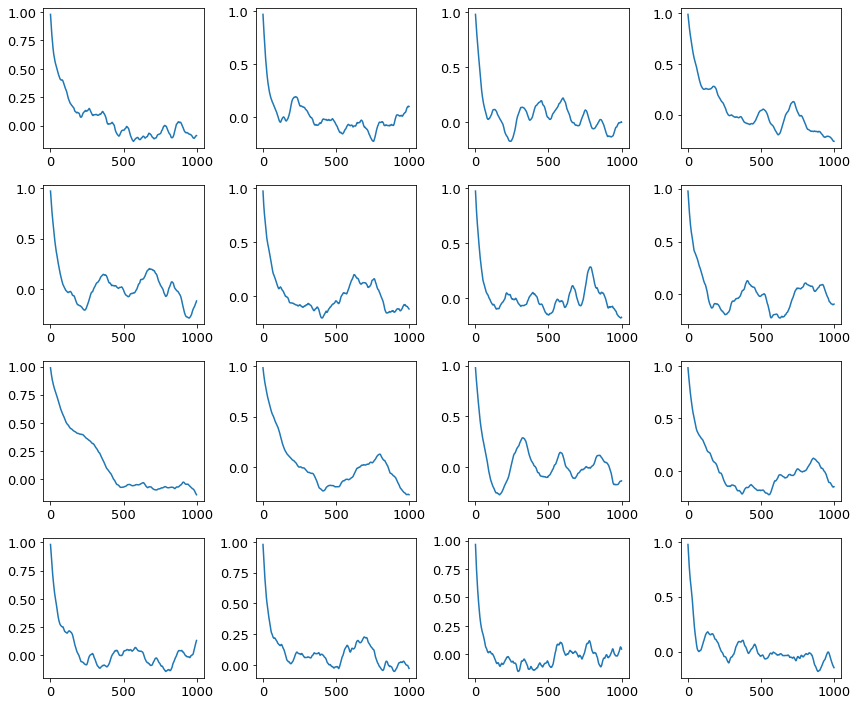

In [60]:
# plot auto-correlation

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
max_lag = 1000
for i in range(len(axs)):
    auto_cor = []
    mean = np.mean(parameters[:, i])
    var = np.var(parameters[:, i])
    for lag in range(1, max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
    axs[i].plot(np.arange(1, max_lag), auto_cor)
plt.tight_layout()
plt.show()

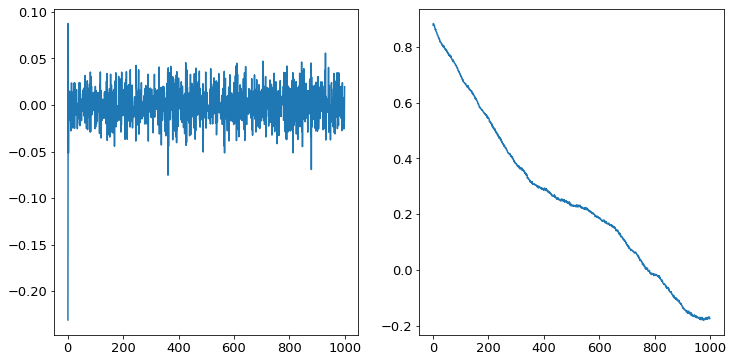

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1, max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[0].plot(np.arange(1, max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1, max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[1].plot(np.arange(1, max_lag), auto_cor)
plt.show()

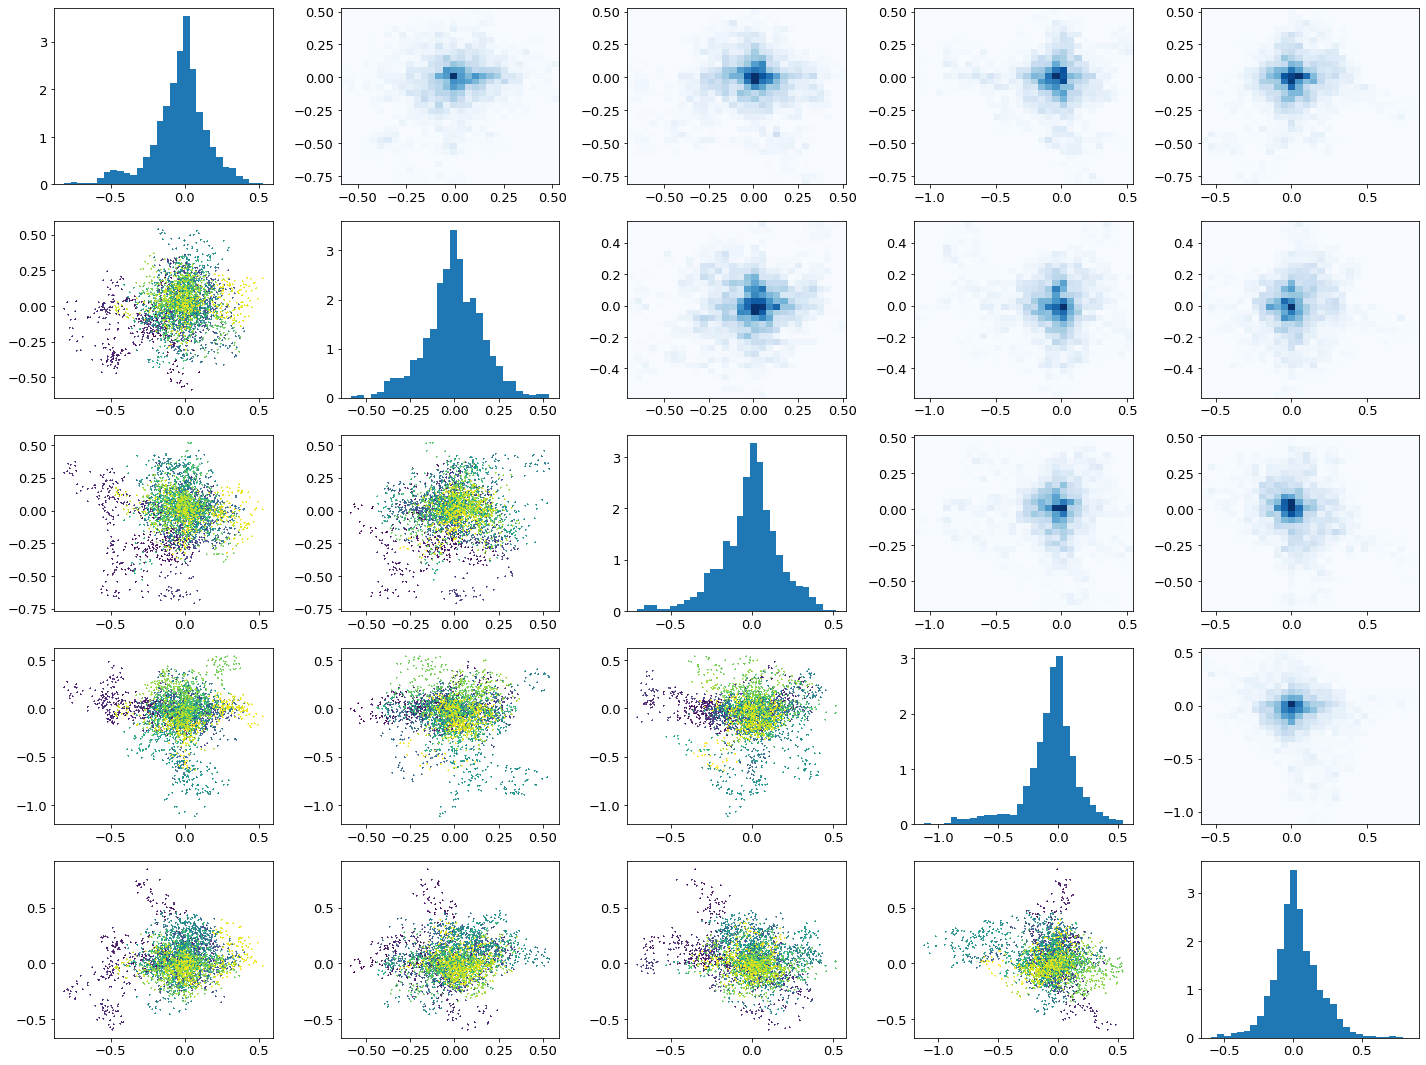

In [62]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(axs.shape[0]):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, axs.shape[0]):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.tight_layout()
plt.show()

In [63]:
def diag_line(x, y, ax, SIF=False, color='black', xy=(.05, .76)):
    # remove NAN values in x, y series
    x, y = x.to_frame(), y.to_frame()
    x_y = pd.concat([x, y], axis=1)

    if x_y.isnull().values.any():
        x_y = x_y.dropna()

    x, y = x_y.iloc[:, 0], x_y.iloc[:, 1]

    max_value = max(max(x), max(y))
    min_value = min(min(x), min(y))
    mean_value = np.mean(x)

    line = np.linspace(min_value, max_value, 100)
    ax.plot(line, line, '--', color=color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    RMSE = (((y - x) ** 2).mean()) ** .5

    ax.annotate(
        f'$N$ = {len(x)} \n$R^{2}$ = {np.around(r_value ** 2, decimals=3)} \n$RMSE$ = {np.around(RMSE, decimals=3)}',
        xy=xy, xycoords='axes fraction')

In [64]:
test['NEE_NN'] = NEE_test_MAP
test['Reco_NN'] = Reco_test_MAP
test['GPP_NN'] = GPP_test_MAP

train['NEE_NN'] = NEE_train_MAP
train['Reco_NN'] = Reco_train_MAP
train['GPP_NN'] = GPP_train_MAP

test_sort = test.sort_index()
train_sort = train.sort_index()

train_day = train[train.APAR_label == 1]
train_night = train[train.APAR_label == 0]
test_day = test[test.APAR_label == 1]
test_night = test[test.APAR_label == 0]

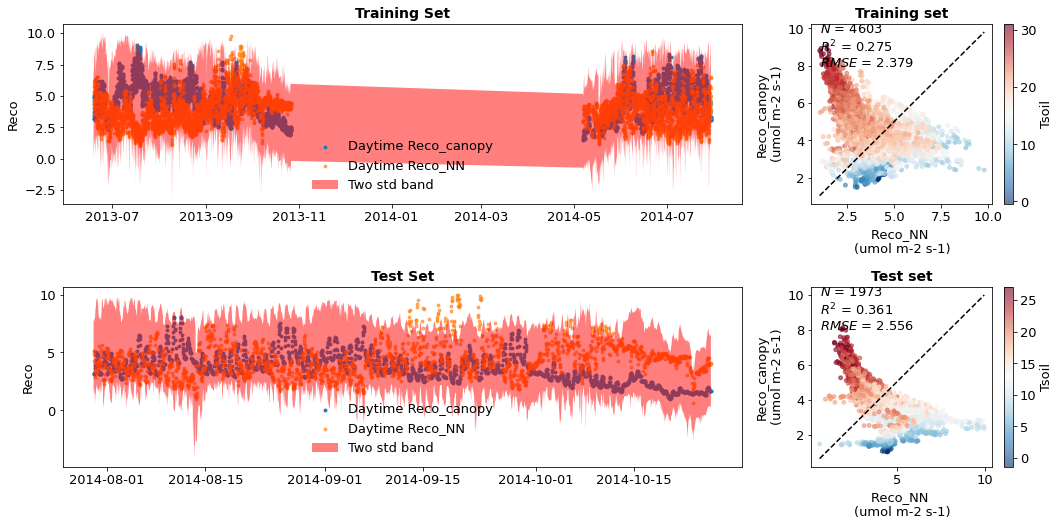

In [65]:
fig, ax = plt.subplots(figsize=(15, 7.5), nrows=2, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
s_circle = 8

colors = 'Tsoil'
cmap = 'RdBu_r'
s = 15
alpha = 0.6
Reco_ref = 'Reco_canopy'

ax[0, 0].scatter(train.index, train[Reco_ref], label='Daytime ' + Reco_ref, s=s_circle)
ax[0, 0].scatter(train.index, train['Reco_NN'], label='Daytime Reco_NN', s=s_circle, alpha=0.6)
lower = mu_Reco_train - 2 * np.sqrt(sigma_Reco_pred_train)
upper = mu_Reco_train + 2 * np.sqrt(sigma_Reco_pred_train)
ax[0, 0].fill_between(train.index, lower, upper, facecolor="red", alpha=0.5, label="Two std band")
ax[0, 0].set_ylabel('Reco')
ax[0, 0].set_title('Training Set', fontsize=14, fontweight='bold')

ax[1, 0].scatter(test.index, test[Reco_ref], label='Daytime ' + Reco_ref, s=s_circle)
ax[1, 0].scatter(test.index, test['Reco_NN'], label='Daytime Reco_NN', s=s_circle, alpha=0.6)
lower = mu_Reco_test - 2 * np.sqrt(sigma_Reco_pred_test)
upper = mu_Reco_test + 2 * np.sqrt(sigma_Reco_pred_test)
ax[1, 0].fill_between(test.index, lower, upper, facecolor="red", alpha=0.5, label="Two std band")
ax[1, 0].set_ylabel('Reco')
ax[1, 0].set_title('Test Set', fontsize=14, fontweight='bold')

train.plot('Reco_NN', Reco_ref, alpha=alpha, ax=ax[0, 1], kind='scatter', s=15, c=colors, cmap=cmap)
test.plot('Reco_NN', Reco_ref, alpha=alpha, ax=ax[1, 1], kind='scatter', s=15, c=colors, cmap=cmap)

ax[0, 1].set_xlabel('Reco_NN \n(umol m-2 s-1)')
ax[0, 1].set_ylabel('' + Reco_ref + '\n(umol m-2 s-1)')
ax[1, 1].set_xlabel('Reco_NN \n(umol m-2 s-1)')
ax[1, 1].set_ylabel('' + Reco_ref + '\n(umol m-2 s-1)')

diag_line(train['Reco_NN'], train[Reco_ref], ax=ax[0, 1])
diag_line(test['Reco_NN'], test[Reco_ref], ax=ax[1, 1])

ax[0, 1].set_title('Training set', fontsize=14, fontweight='bold')
ax[1, 1].set_title('Test set', fontsize=14, fontweight='bold')

for each_ax in ax[:, 0]:
    each_ax.legend(loc='best')

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
T = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# plt.savefig('./FIGURE/NNSIF/SCOPE_Reco_'+str(i)+'.png')

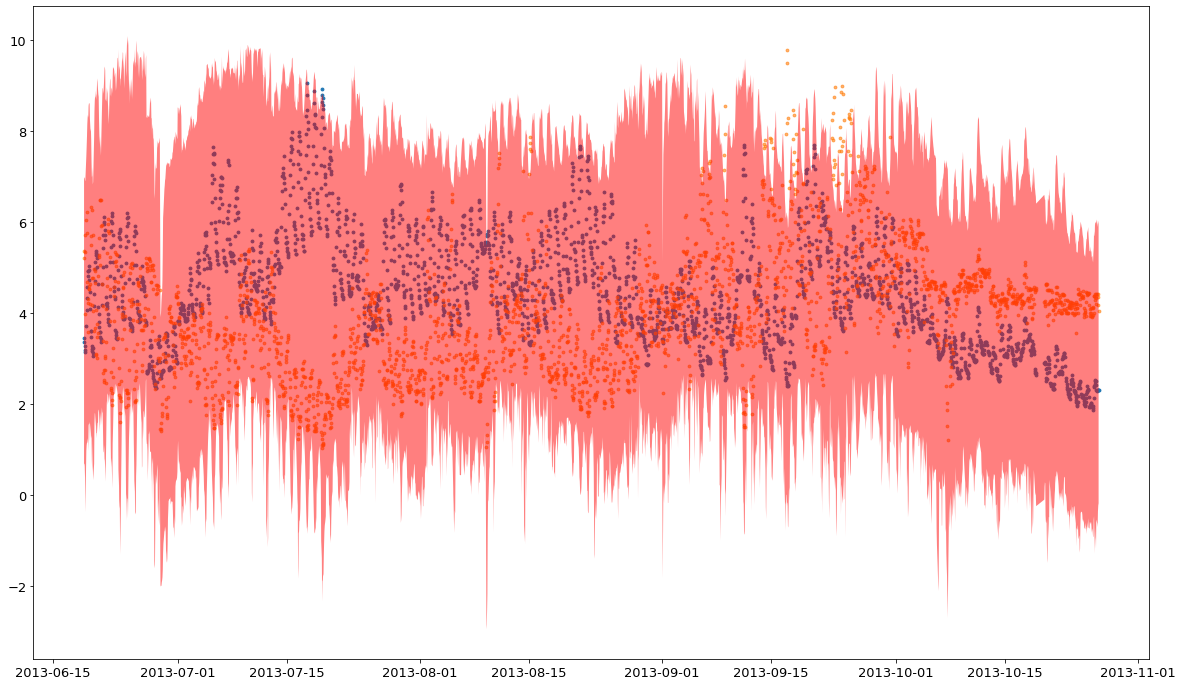

In [66]:
fig = plt.figure(figsize=(20, 12))
df = train[train.index < dt.datetime(2014,1,1)]
n = df.shape[0]

plt.scatter(df.index, df[Reco_ref], label='Daytime ' + Reco_ref, s=s_circle)
plt.scatter(df.index, df['Reco_NN'], label='Daytime Reco_NN', s=s_circle, alpha=0.6)
lower = mu_Reco_train[:n] - 2 * np.sqrt(sigma_Reco_pred_train[:n])
upper = mu_Reco_train[:n] + 2 * np.sqrt(sigma_Reco_pred_train[:n])
plt.fill_between(df.index, lower, upper, facecolor="red", alpha=0.5, label="Two std band")
plt.show()